## Modules

In [1]:
import pandas as pd
import warnings
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
from matplotlib import style
from matplotlib.pyplot import plot
from matplotlib import pyplot
from matplotlib.collections import PolyCollection
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [3]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
import scipy.stats as stats

## Get Training Data

In [4]:
training = pd.read_csv(os.getcwd() + "/Data/training.csv")
print(training)

           DATE      GDPC1
0    1947-01-01   2033.061
1    1947-04-01   2027.639
2    1947-07-01   2023.452
3    1947-10-01   2055.103
4    1948-01-01   2086.017
..          ...        ...
276  2016-01-01  17613.264
277  2016-04-01  17668.203
278  2016-07-01  17764.388
279  2016-10-01  17876.179
280  2017-01-01  17977.299

[281 rows x 2 columns]


In [5]:
training["DATE"] = pd.to_datetime(training["DATE"])
training = training.set_index("DATE")

In [6]:
# training = training.pct_change()

## Model Evaluation

In [7]:
training_size = int(len(training) * 0.7)
train, val = training[0:training_size], training[training_size:]

In [8]:
def evaluate_model(training, validation, order):
    history = [x for x in training.values]
    predictions = list()
    for t in range(len(val.values)):
        model = ARIMA(history, order = order)
        model_fit = model.fit()
        y_hat = model_fit.forecast()[0] 
        predictions.append(y_hat)
        history.append(validation.values[t])
    rmse = np.sqrt(mean_squared_error(validation.values, predictions))
    model_data = validation.copy()
    model_data["prediction"] = predictions
    return rmse, model_data

In [9]:
def grid_search(training, validation, p_values, d, q_values):
    best_score, best_cfg = float("inf"), None
    rmse_values = list()
    for p in p_values:
        for q in q_values:
            order = (p,d,q)
            try:
                rmse, model_data = evaluate_model(training, validation, order)
                if rmse < best_score:
                    best_score, best_cfg = rmse, order
                print("ARIMA%s -> RMSE = %.3f" % (order, rmse))
                rmse_values.append(rmse)
            except:
                continue
    print("Best ARIMA%s with RMSE of %.3f" % (best_cfg, best_score))
    return best_cfg, model_data, rmse_values

In [10]:
def plot_model(training, model_data, predictions):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16,6))
    
    ax1.plot(model_data.iloc[:,0], color = "darkblue", label = "Validation Data")
    ax1.plot(model_data.iloc[:,1], color = "red", label = "Fitted Values", linestyle = "--")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Real GDP")
    ax1.set_title("Model Training for best ARIMA Combination", loc = "left")
    ax1.tick_params(direction = "in")
    ax1.grid(axis = "y", linewidth = 0.5, linestyle = ":")
    ax1.legend(frameon = False)
    
    ax2.plot(predictions, color = "green")
    ax2.set_xlabel("Iteration of ARIMA Combinations")
    ax2.set_ylabel("RMSE Value")
    ax2.set_title("Corresponding RMSE", loc = "left")
    ax2.tick_params(direction = "in")
    ax2.grid(axis = "y", linewidth = 0.5, linestyle = ":")

In [11]:
p = range(0, 4)
q = range(0, 2)
d = 1
warnings.filterwarnings("ignore")
best_cfg, model_data, rmse_values = grid_search(train, val, p, d, q)

ARIMA(0, 1, 0) -> RMSE = 122.399
ARIMA(0, 1, 1) -> RMSE = 105.313
ARIMA(1, 1, 0) -> RMSE = 92.247
ARIMA(1, 1, 1) -> RMSE = 85.928
ARIMA(2, 1, 0) -> RMSE = 87.336
ARIMA(2, 1, 1) -> RMSE = 86.672
ARIMA(3, 1, 0) -> RMSE = 87.024
ARIMA(3, 1, 1) -> RMSE = 83.778
Best ARIMA(3, 1, 1) with RMSE of 83.778


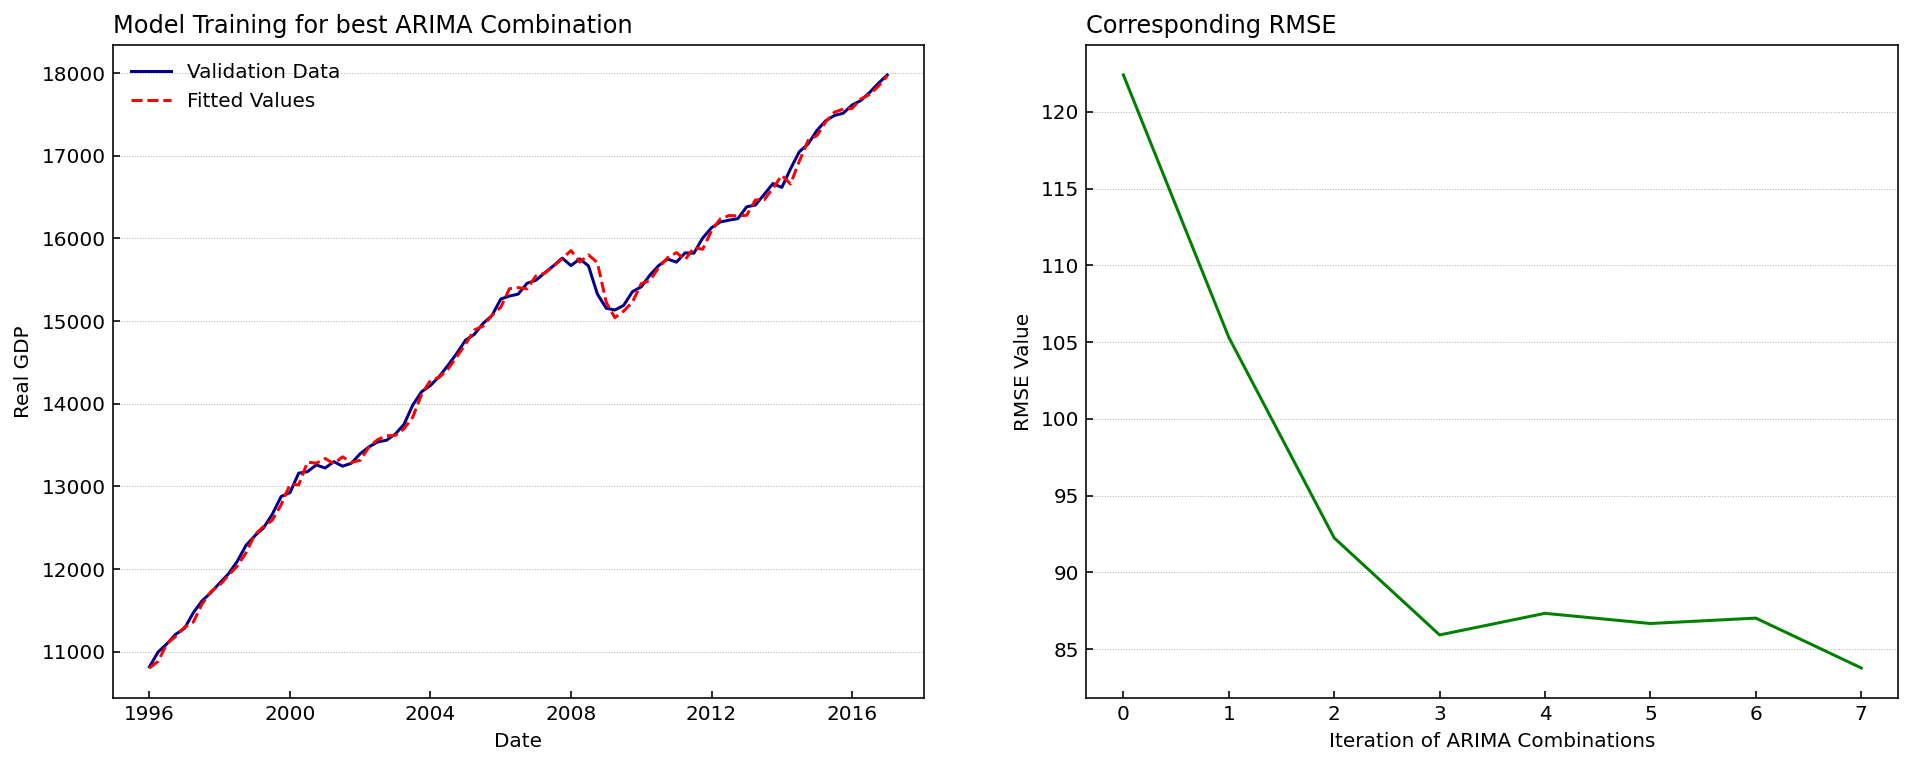

In [12]:
plot_model(train, model_data, rmse_values)

## Residual Diagnostics

In [13]:
def plot_residuals(data, order):
    model = ARIMA(data, order = order)
    model_fit = model.fit()
    residuals = pd.DataFrame(model_fit.resid)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16,6))
    
    ax1.plot(residuals, color = "darkblue")
    ax1.axhline(y = 0, color = "red", linestyle = "--")
    ax1.set_xlabel("Date")
    ax1.set_title("Residuals", loc = "left")
    ax1.tick_params(direction = "in")
    ax1.grid(axis = "y", linewidth = 0.5, linestyle = ":")
    
    plot_acf(residuals, ax = ax2, title = "", zero = False, color = "darkblue", 
             vlines_kwargs = {"colors": "darkblue"}, lags = int(len(data)) - 1, use_vlines = False)
    ax2.axhline(y = 0, color = "red", linestyle = "--")
    ax2.set_title("Autocorrelation Function of Residuals", loc = "left")
    ax2.set_xlabel("Lags")
    ax2.set_ylabel("Correlation")
    ax2.tick_params(direction = "in")
    ax2.grid(axis = "y", linewidth = 0.5, linestyle = ":")
    for item in ax2.collections:
        if type(item) == PolyCollection:
            item.set_facecolor("blue")
            
    return residuals

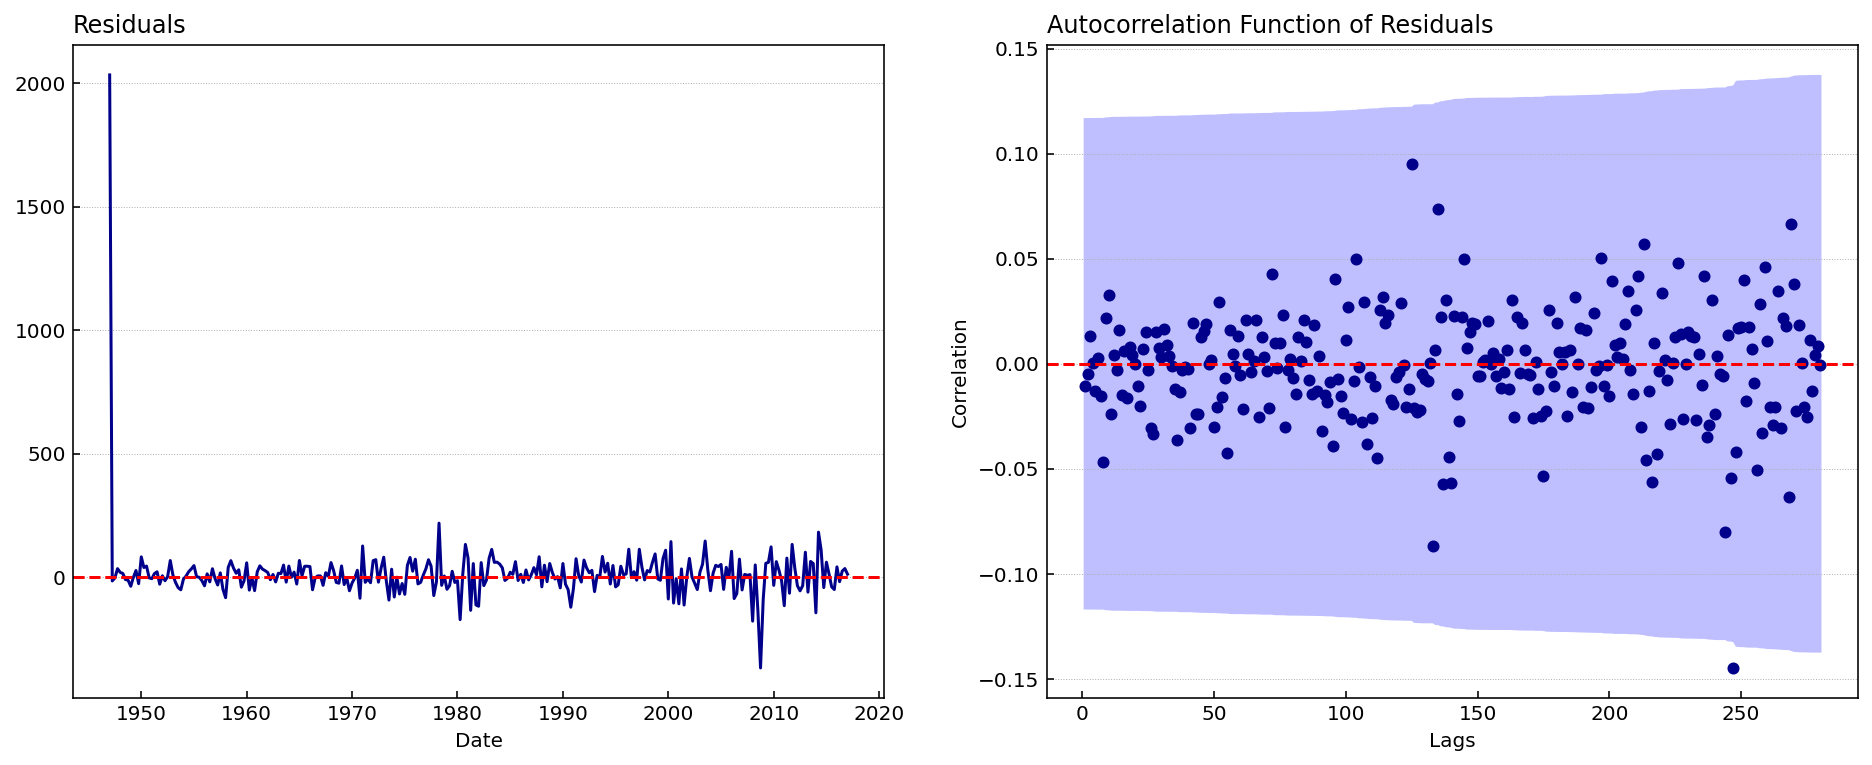

In [14]:
residuals = plot_residuals(training, best_cfg)

## Forecasting on Test Data

In [15]:
testing = pd.read_csv(os.getcwd() + "/Data/testing.csv")
testing["DATE"] = pd.to_datetime(testing["DATE"])
testing = testing.set_index("DATE")

In [16]:
# testing = testing.pct_change()

In [17]:
def forecast(training, testing, order):
    model = ARIMA(training, order = order)
    model_fit = model.fit()
    y_hat = model_fit.forecast(steps = len(testing))
    rmse = np.sqrt(mean_squared_error(testing, y_hat))
    print("RMSE = " + str(rmse))
    return y_hat

In [18]:
y_hat = forecast(training, testing, best_cfg)

RMSE = 518.2321573324613


In [19]:
def plot_forecast(training, testing, y_hat):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16,6))
    
    ax1.plot(training, color = "darkblue", label = "Training Data")
    ax1.plot(testing, color = "green", label = "Test Data")
    ax1.plot(y_hat, color = "red", label = "Forecasted Values")
    ax1.set_xlabel("Date")
    ax1.set_title("Forecast", loc = "left")
    ax1.legend(frameon = False)
    ax1.tick_params(direction = "in")
    ax1.grid(axis = "y", linewidth = 0.5, linestyle = ":")
    
    ax2.plot(testing, color = "green")
    ax2.plot(y_hat, color = "red")
    ax2.set_xlabel("Date")
    ax2.set_title("Forecast (zoomed-in)", loc = "left")
    ax2.tick_params(direction = "in")
    ax2.grid(axis = "y", linewidth = 0.5, linestyle = ":")

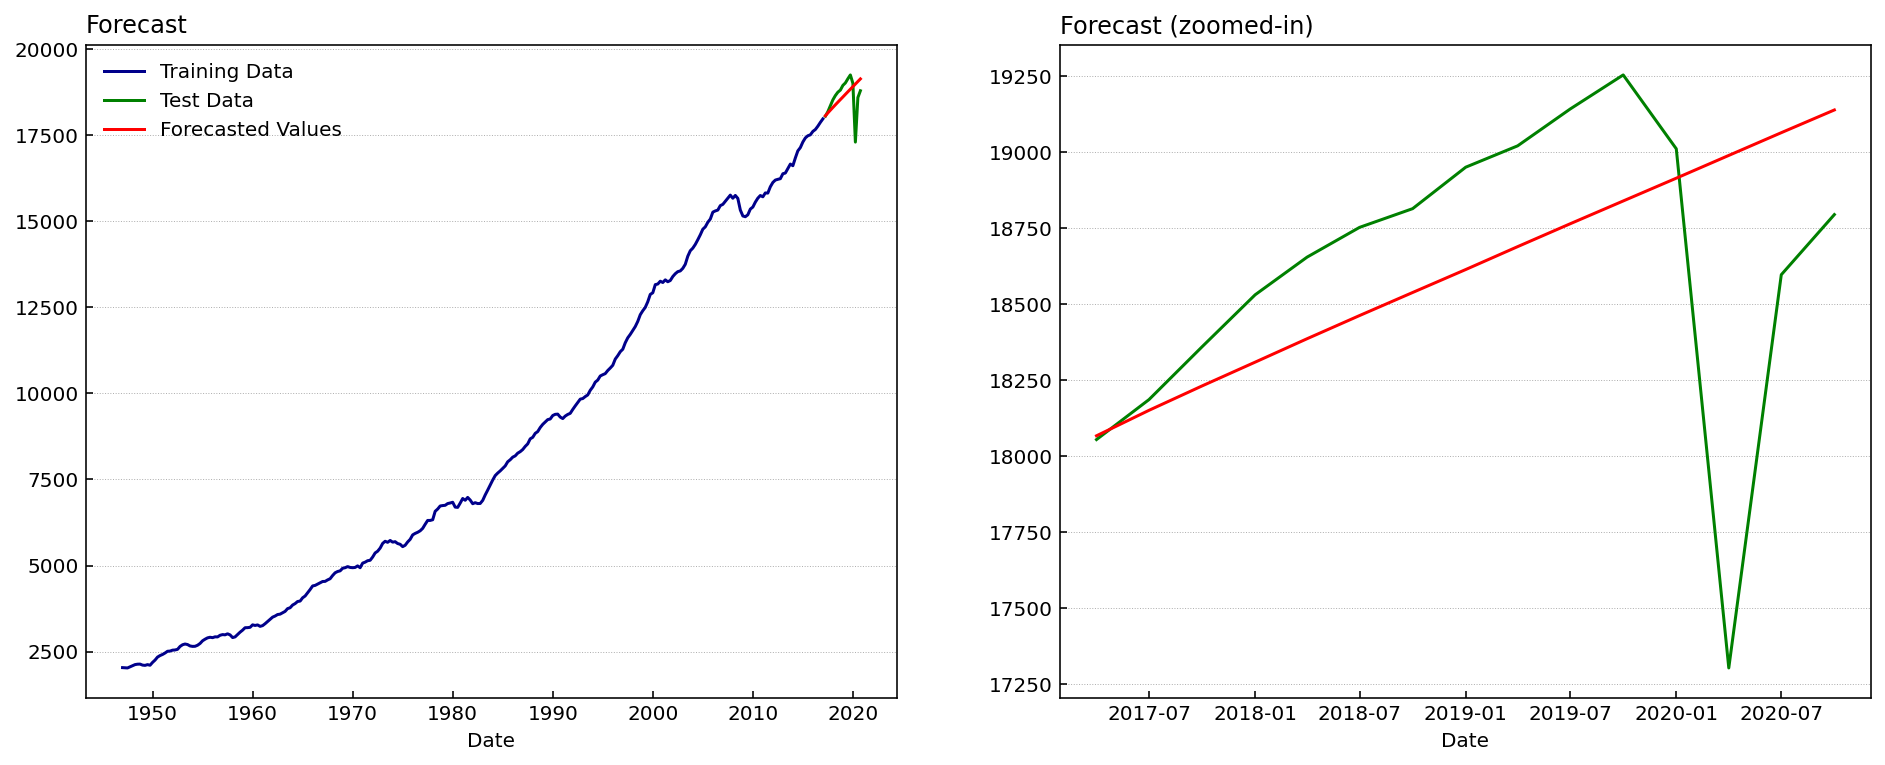

In [20]:
plot_forecast(training, testing, y_hat)